In [1]:
!pip install ultralytics

  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
   ---------------------------------------- 0.0/911.6 kB ? eta -:--:--
   --------------------------------------- 911.6/911.6 kB 14.1 MB/s eta 0:00:00
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


In [2]:
from ultralytics import YOLO
import os
import shutil
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def prepare_images(initial_training_dir):
    for character in ['dad', 'mom', 'dexter', 'deedee']:
        character_dir = os.path.join(initial_training_dir, character)
        for image in os.listdir(character_dir):
            image_path = os.path.join(character_dir, image)
            new_image_name = f'{character}_{image}'
            new_image_path = os.path.join('datasets', train_data_dir, 'images', new_image_name)
            if not os.path.exists(new_image_path):
                shutil.copy(image_path, new_image_path)

def convert_annotations(input_file, character, output_dir, images_dir):
    os.makedirs(output_dir, exist_ok=True)

    with open(input_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        img_name = parts[0]
        x_min, y_min, x_max, y_max = map(int, parts[1:5])
        label = parts[5]
        
        # print(img_name)
        img_name = f'{character}_{img_name}'
        # print(images_dir)
        # print(img_name)

        # YOLO format: class_id x_center y_center width height (normalized)
        img_path = os.path.join(images_dir, img_name)
        img_width, img_height = get_image_dimensions(img_path)

        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        class_id = label_to_class_id(label)

        label_file = os.path.join(output_dir, img_name.replace('.jpg', '.txt'))
        with open(label_file, "a") as label_f:
            label_f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def label_to_class_id(label):
    classes = {"dad": 0, "mom": 1, "dexter": 2, "deedee": 3, "unknown": 4}
    return classes[label]

def class_id_to_label(class_id):
    classes = {0: "dad", 1: "mom", 2: "dexter", 3: "deedee", 4: "unknown"}
    return classes[class_id]

def get_image_dimensions(image_path):
    img = cv.imread(image_path)
    return img.shape[1], img.shape[0]

def train_yolo(data_yaml, model='yolov8n', epochs=50):
    model = YOLO(model)
    model.train(data=data_yaml, epochs=epochs)

def test_yolo(model_path, test_images_dir, project, name, conf=0.25):
    model = YOLO(model_path)
    results = model.predict(source=test_images_dir, conf=conf, save=True, save_txt=True, save_conf=True, project=project, name=name)

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\vciup\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
class Parameters:
    def __init__(self):
        
        # kaggle
        #self.base_dir = '/kaggle/input/cava-trainingdata-yolo'
        # here, we created a dataset as cava-trainingdata-yolo by uploading
        # the zip created from the /antrenare, /validare, /evaluare, /testare folders
        # currently, the /testare folder contains the same images as the /validare/validare one
        # but this should be changed for the actual run
        self.base_dir = './'
        
        self.dir_train_examples = os.path.join(self.base_dir, 'antrenare')
        # when the test data is uploaded, here, the dir_text_examples should be changed
        # to /testare
        self.dir_test_examples = os.path.join(self.base_dir,'testare')
        
        self.use_small_batch = False 
        self.path_annotations = os.path.join(self.base_dir, 'validare/task1_gt_validare.txt')
        
        self.path_annotations_characters = {'dad': None, 'mom': None, 'dexter': None, 'deedee': None}
        for character in ['dad', 'mom', 'dexter', 'deedee']:
            self.path_annotations_characters[character] = os.path.join(self.base_dir, f'validare/task2_{character}_gt_validare.txt')
        
        # kaggle
        #self.dir_save_files = os.path.join('/kaggle/working/', 'salveazaFisiere')
        self.dir_save_files = os.path.join('./', 'salveazaFisiere')
        
        
        if not os.path.exists(self.dir_save_files):
            os.makedirs(self.dir_save_files)
            print('directory created: {} '.format(self.dir_save_files))
        else:
            print('directory {} exists '.format(self.dir_save_files))

        # set the parameters
        # TODO: aici poate facem separat pentru fiecare personaj in parte
        self.dim_window = 36  # exemplele pozitive (fete de oameni cropate) au 36x36 pixeli
        self.dim_hog_cell = 6  # dimensiunea celulei
        self.overlap = 0.3
        self.number_positive_examples = 6713  # numarul exemplelor pozitive
        self.number_negative_examples = 10000  # numarul exemplelor negative
        self.has_annotations = False
        self.threshold = 0
        self.use_hard_mining = True  # (optional) antrenare cu exemple puternic negative
        self.use_flip_images = True  # adaugam imaginile cu fete oglindite

        self.characters = ['dad', 'mom', 'dexter', 'deedee', 'face']
        self.images_faces = {} # for each image, extract the identified faces - (x_min, y_min, x_max, y_max)
        self.characters_faces = {} # for each character, extract their identified faces and the image path
        self.character_aspect_ratio = {'dad': 0.85, 'mom': 0.90, 'dexter': 1.25, 'deedee': 1.45, 'face': 1, 'unknown': 1} # dif x / dif y = width / height
        # kaggle
        self.dir_hard_mining = os.path.join('/kaggle/working/', 'hard_mining')
        self.windows = ['vertical_rectangle', 'horizontal_rectangle', 'square']
        self.window_aspect_ratio = {'vertical_rectangle': -0.75, 'horizontal_rectangle': 1.5, 'square': 1}

        # kaggle
        # self.final_save_dir = '/kaggle/working/yolo/351_Ciuperceanu_Vlad'
        # self.task1_save_dir = '/kaggle/working/yolo/351_Ciuperceanu_Vlad/task1'
        # self.task2_save_dir = '/kaggle/working/yolo/351_Ciuperceanu_Vlad/task2'
        self.final_save_dir = './yolo/351_Ciuperceanu_Vlad'
        self.task2_save_dir = './yolo/351_Ciuperceanu_Vlad/task2'
        self.task1_save_dir = './yolo/351_Ciuperceanu_Vlad/task1'
        # on local, this can be renamed as above in order to not have conflicts of folders
        # then we can take only the needed folder inside of /yolo
        # or, if run separately, it's also fine to remove the extra /yolo folder
        if not os.path.exists(self.final_save_dir):
            os.makedirs(self.final_save_dir)
        if not os.path.exists(self.task1_save_dir):
            os.makedirs(self.task1_save_dir)
        if not os.path.exists(self.task2_save_dir):
            os.makedirs(self.task2_save_dir)
            
def compute_average_precision(rec, prec):
    # functie adaptata din 2010 Pascal VOC development kit
    m_rec = np.concatenate(([0], rec, [1]))
    m_pre = np.concatenate(([0], prec, [0]))
    for i in range(len(m_pre) - 1, -1, 1):
        m_pre[i] = max(m_pre[i], m_pre[i + 1])
    m_rec = np.array(m_rec)
    i = np.where(m_rec[1:] != m_rec[:-1])[0] + 1
    average_precision = np.sum((m_rec[i] - m_rec[i - 1]) * m_pre[i]) # aria de sub curba, calc ca suma ariilor dreptunghiurilor
    return average_precision

def intersection_over_union(bbox_a, bbox_b):
    x_a = max(bbox_a[0], bbox_b[0])
    y_a = max(bbox_a[1], bbox_b[1])
    x_b = min(bbox_a[2], bbox_b[2])
    y_b = min(bbox_a[3], bbox_b[3])

    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

    box_a_area = (bbox_a[2] - bbox_a[0] + 1) * (bbox_a[3] - bbox_a[1] + 1)
    box_b_area = (bbox_b[2] - bbox_b[0] + 1) * (bbox_b[3] - bbox_b[1] + 1)

    if float(box_a_area + box_b_area - inter_area) == 0:
        print('Found division by zero!')
        print('Box a and box b', bbox_a, bbox_b)
        print('coord xa ya xb yb', x_a, y_a, x_b, y_b)
        print('inter area, box_a_area, box_b_area', inter_area, box_a_area, box_b_area)
        return 0.0

    iou = inter_area / float(box_a_area + box_b_area - inter_area)

    return iou

def eval_detections(detections, scores, file_names, given_path_annotations, extra=''):
    ground_truth_file = np.loadtxt(given_path_annotations, dtype='str')
    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], np.int32)
    print(given_path_annotations)

    num_gt_detections = len(ground_truth_detections)  # numar total de adevarat pozitive
    gt_exists_detection = np.zeros(num_gt_detections)
    # sorteazam detectiile dupa scorul lor
    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]
    scores = scores[sorted_indices]
    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]

        # clasifica o detectie ca fiind adevarat pozitiva / fals pozitiva
        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                false_positive[detection_idx] = 1
                duplicated_detections[detection_idx] = 1
        else:
            false_positive[detection_idx] = 1

    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average precision %.3f' % average_precision)
    plt.savefig(os.path.join(params.dir_save_files, f'precizie_medie{extra}.png'))
    plt.show()
    
def save_task1(detections, scores, file_names):
    np.save(os.path.join(params.task1_save_dir, f'detections_all_faces.npy'), detections, allow_pickle=True, fix_imports=True)
    np.save(os.path.join(params.task1_save_dir, f'scores_all_faces.npy'), scores, allow_pickle=True, fix_imports=True)
    np.save(os.path.join(params.task1_save_dir, f'file_names_all_faces.npy'), file_names, allow_pickle=True, fix_imports=True)

def save_task2(character_detections, character_scores, character_file_names):
    for character in params.characters:
        if character == 'face':
            continue
        np.save(os.path.join(params.task2_save_dir, f'detections_{character}.npy'), character_detections[character], allow_pickle=True, fix_imports=True)
        np.save(os.path.join(params.task2_save_dir, f'scores_{character}.npy'), character_scores[character], allow_pickle=True, fix_imports=True)
        np.save(os.path.join(params.task2_save_dir, f'file_names_{character}.npy'), character_file_names[character], allow_pickle=True, fix_imports=True)

params: Parameters = Parameters()
params.overlap = 0.3

directory created: ./salveazaFisiere 


In [4]:
if not os.path.exists('./datasets'):
    os.makedirs('./datasets')
    os.makedirs('./datasets/train')
    os.makedirs('./datasets/train/labels')
    os.makedirs('./datasets/train/images')
train_data_dir = "./train"
output_labels_dir = "./datasets/train/labels"
test_images_dir = params.dir_test_examples
# /kaggle/working/ should be replaced everywhere with ./ on local
# as well as /kaggle/input/
# otherwise, this can be run directly in kaggle notebook
# the directories - /datasets, /train, /runs, as well as the yaml file need to be kept in the
# same way for this to work

# if the model is already trained, this is not needed anymore (it was used to train the model)
# we can just directly use it for testing; otherwise, uncomment the lines below

# prepare_images(params.dir_train_examples)
# for character in ['dad', 'mom', 'dexter', 'deedee']:
#     annotations_file = os.path.join(params.dir_train_examples, f'{character}_annotations.txt')
#     convert_annotations(annotations_file, character, output_labels_dir, os.path.join('/kaggle/working/datasets', train_data_dir, 'images'))

In [5]:
# same, used for training the model with our data

# data_yaml = "./yolo.yaml"
# with open(data_yaml, "w") as yaml_file:
#     yaml_file.write(f"""
#         path: .
#         train: {train_data_dir}
#         val: {train_data_dir}
#         test: {test_images_dir}
#         nc: 5  # Number of classes
#         names: ['dad', 'mom', 'dexter', 'deedee', 'unknown']
#     """)

In [6]:
# training the model

#train_yolo(data_yaml)

In [7]:
project = './' # again, this should be replaced with ./ if run locally
name = 'results' # this is here for custom folder of getting the results

# this version is for training the model and then testing it 
# it should be /kaggle/working/runs/detect/train/weights/best.pt, the 2 is for running multiple times
#test_yolo("/kaggle/working/runs/detect/train2/weights/best.pt", test_images_dir, project, name)

# but now we will just load the model directly (we uploaded it in kaggle input as well)
# naming it 'yolo-model-trained'
# when downloading it for local, it changes to 'yolo-model-trained-other-default-1'
test_yolo("./yolo-model-trained-other-default-v1/best.pt", test_images_dir, project, name)


image 1/200 c:\Users\vciup\Desktop\yolo - try\testare\001.jpg: 480x640 1 dad, 215.9ms
image 2/200 c:\Users\vciup\Desktop\yolo - try\testare\002.jpg: 480x640 1 dad, 133.6ms
image 3/200 c:\Users\vciup\Desktop\yolo - try\testare\003.jpg: 480x640 1 dexter, 119.6ms
image 4/200 c:\Users\vciup\Desktop\yolo - try\testare\004.jpg: 480x640 1 dexter, 7 unknowns, 129.8ms
image 5/200 c:\Users\vciup\Desktop\yolo - try\testare\005.jpg: 480x640 1 dexter, 1 unknown, 242.6ms
image 6/200 c:\Users\vciup\Desktop\yolo - try\testare\006.jpg: 480x640 1 dexter, 1 unknown, 220.2ms
image 7/200 c:\Users\vciup\Desktop\yolo - try\testare\007.jpg: 480x640 1 deedee, 279.0ms
image 8/200 c:\Users\vciup\Desktop\yolo - try\testare\008.jpg: 480x640 1 dexter, 2 unknowns, 394.0ms
image 9/200 c:\Users\vciup\Desktop\yolo - try\testare\009.jpg: 480x640 1 dexter, 247.1ms
image 10/200 c:\Users\vciup\Desktop\yolo - try\testare\010.jpg: 480x640 1 deedee, 161.1ms
image 11/200 c:\Users\vciup\Desktop\yolo - try\testare\011.jpg: 480x

In [8]:
annotations_dir = os.path.join("./results", 'labels')
conf = 0.25

detections = []
scores = []
file_names = []
classes = []

for file_name in os.listdir(annotations_dir):
    if file_name.endswith(".txt"):
        with open(os.path.join(annotations_dir, file_name), 'r') as f:
            lines = f.readlines()
            
            image_path = os.path.join(test_images_dir, file_name.replace('.txt', '.jpg'))
            img = cv.imread(image_path)
            img_width, img_height = img.shape[1], img.shape[0]
            
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                score = float(parts[5])
                
                if score >= conf:
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    x1 = (x_center - width / 2) * img_width
                    y1 = (y_center - height / 2) * img_height
                    x2 = (x_center + width / 2) * img_width
                    y2 = (y_center + height / 2) * img_height
                    
                    detections.append([x1, y1, x2, y2])
                    scores.append(score)
                    classes.append(class_id_to_label(class_id))
                    file_names.append(file_name.replace('.txt', '.jpg'))
                    
detections = np.array(detections)
scores = np.array(scores)
file_names = np.array(file_names)
classes = np.array(classes)

In [9]:
# task 1: detect all faces

save_task1(detections, scores, file_names)

In [11]:
# task 2: detect characters

character_detections = {'dad': [], 'mom': [], 'dexter': [], 'deedee': []}
character_scores = {'dad': [], 'mom': [], 'dexter': [], 'deedee': []}
character_file_names = {'dad': [], 'mom': [], 'dexter': [], 'deedee': []}

for i, detection in enumerate(detections):
    if classes[i] in ['dad', 'mom', 'dexter', 'deedee']:
        character_detections[classes[i]].append(detection)
        character_scores[classes[i]].append(scores[i])
        character_file_names[classes[i]].append(file_names[i])

for character in ['dad', 'mom', 'dexter', 'deedee']:
    character_detections[character] = np.array(character_detections[character])
    character_scores[character] = np.array(character_scores[character])
    character_file_names[character] = np.array(character_file_names[character])
    
save_task2(character_detections, character_scores, character_file_names)

./validare/task1_gt_validare.txt


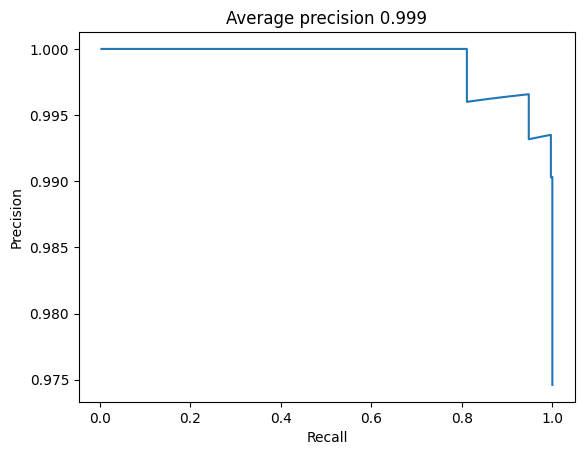

./validare/task2_dad_gt_validare.txt


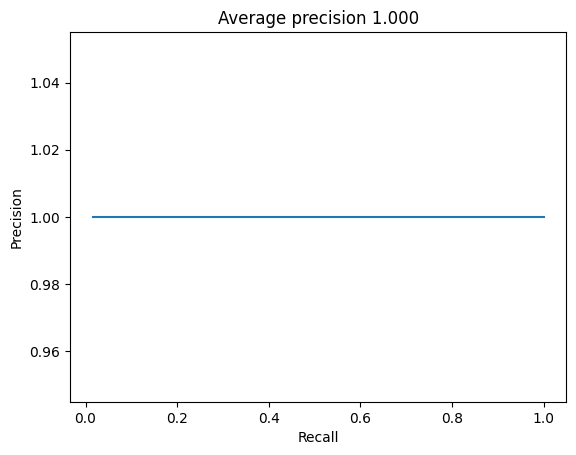

./validare/task2_mom_gt_validare.txt


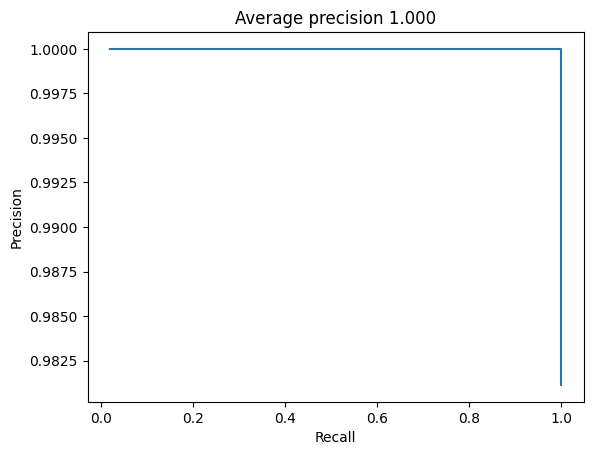

./validare/task2_dexter_gt_validare.txt


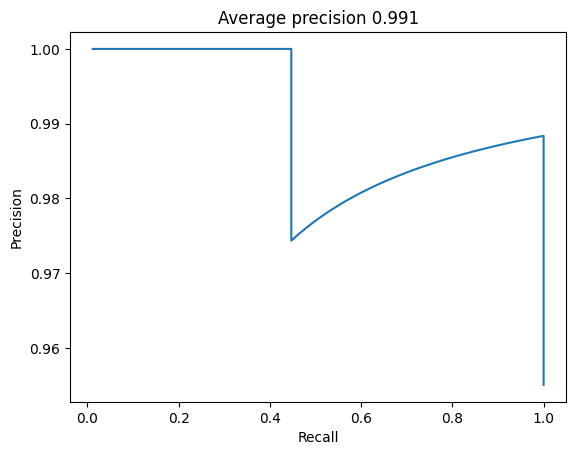

./validare/task2_deedee_gt_validare.txt


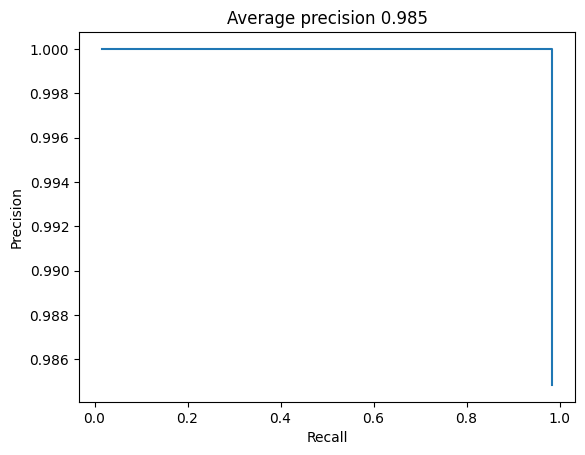

In [12]:
# this is only for the validation process, it should not be run on testing
# since we don't have annotations
# we might as well comment it

params.has_annotations = True

# task 1 evaluation
if params.has_annotations:
    eval_detections(detections, scores, file_names, params.path_annotations)

# task 2 evaluation
if params.has_annotations:
    for character in ['dad', 'mom', 'dexter', 'deedee']:
        eval_detections(character_detections[character], character_scores[character], character_file_names[character], params.path_annotations_characters[character], extra=f'_{character}')

In [ ]:
# only in kaggle notebook, to extract all outputs (and everything created)
# the needed folder would be inside /yolo, with all our detections, scores and files names
# for the 2 tasks

#!zip -r /kaggle/working/after_training.zip /kaggle/working/